In [ ]:
# COMP4600/5300 final project part 3 - implementation
# Adrienne Curtis, Joe Scannell, Andrew Farrell, John Lanfranchi

# This file is a Jupyter notebook, and was written for intended use on Google
# Colab with TPUs. To run, import the notebook into a new Colab project, and 
# select TPU as your hardware accelerator inside of the runtime settings.
# Input data is sourced from the MURA Dataset at https://stanfordmlgroup.github.io/competitions/mura/,
# used with permission. The full dataset should be uploaded to Google Drive,
# such that the compressed file is at /content/drive/MyDrive/comp_health_medicine/mura.zip.

!pip install keras_ocr
import keras_ocr
import cv2
import math
from scipy.spatial import distance
import random
import os
import shutil
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator,img_to_array
from sklearn.preprocessing import LabelBinarizer

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Instantiate a 121 layer DenseNet pretrained on the ImageNet dataset, as 
# provided by the Keras libraries. Reference for the pooling layers:
# https://www.pluralsight.com/guides/introduction-to-densenet-with-tensorflow

# I'm converting this to a function as it needs to be in a 
# context manager scope for the TPU's

def generate_densenet121():
  # neat, its already in graph mode, so it should have compiler optimizations
  # per default.
  dn = tf.keras.applications.DenseNet121(weights='imagenet',include_top=False, input_shape=(128, 128, 3))

  x = dn.output

  # DenseNet isn't as frequently used for binary classification problems, so
  # we had to make some changes to accomodate that. Of note, the activation
  # function in the output layer must be sigmoid, and later when the model is
  # compiled we must use binary cross-entropy loss

  x = tf.keras.layers.GlobalAveragePooling2D()(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Dropout(0.5)(x)
  x = tf.keras.layers.Dense(1024,activation='relu')(x) 
  x = tf.keras.layers.Dense(512,activation='relu')(x) 
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Dropout(0.5)(x)

  preds = tf.keras.layers.Dense(1,activation='sigmoid')(x)

  model = tf.keras.Model(inputs = dn.input, outputs = preds)

  # we don't want to touch the imported ImageNet layers - only the layers we 
  # added to the network

  for layer in model.layers[:-8]:
    layer.trainable = False

  for layer in model.layers[-8:]:
    layer.trainable = True

  return model

In [ ]:
# 201 layer densenet - same as above with a different imported model from Keras

def generate_densenet201():
  dn = tf.keras.applications.DenseNet201(weights='imagenet',include_top=False, input_shape=(128, 128, 3))

  x = dn.output

  x = tf.keras.layers.GlobalAveragePooling2D()(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Dropout(0.5)(x)
  x = tf.keras.layers.Dense(1024,activation='relu')(x) 
  x = tf.keras.layers.Dense(512,activation='relu')(x) 
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Dropout(0.5)(x)

  preds = tf.keras.layers.Dense(1,activation='sigmoid')(x)

  model = tf.keras.Model(inputs = dn.input, outputs = preds)

  for layer in model.layers[:-8]:
    layer.trainable = False

  for layer in model.layers[-8:]:
    layer.trainable = True

  return model

In [ ]:
# Categorize the input data by positive/negative class, while preserving 
# relevant metadata in the filename; general file manipulation in the Colab
# runtime

# Most of these are convenience methods to allow us to upload the dataset to
# Google Drive as a compressed file, unzip it inside of the Colab runtime,
# and then rearrange the data such that we achieve a file structure:
# /classified_images/
# ../positive/
# ....image1_positive.jpg
# ....image2_positive.jpg
# ../negative/
# ....image1_negative.jpg
# ....image2_negative.jpg

try:
  os.mkdir("/content/mura")
  os.mkdir("/content/mura/images")
except:
  pass
!unzip /content/drive/MyDrive/comp_health_medicine/mura.zip -d /content/mura/images

SUB_DIR = "MURA-v1.1/train/XR_FINGER/" #todo add the directory

newroot = "/content/classified_images"
srcroot = f"/content/mura/images/{SUB_DIR}"

if not os.path.exists(newroot):
  os.mkdir(newroot)
  os.mkdir(newroot + "positive" + "/")
  os.mkdir(newroot + "negative" + "/")

folders = os.listdir(srcroot)

try:
  os.mkdir(f"{newroot}/negative")
  os.mkdir(f"{newroot}/positive")
except:
  pass

def directory_concat(directory: str, files: list):
  return [f"{directory}/{f}" for f in files]

def file_spider(directory: str):
  all_dirs = os.listdir(directory)
  #print(all_dirs)
  directories_classifications = {
      "positive":[],
      "negative":[],
      "unclassified":[]
    }
  for dir in all_dirs:
    if(os.path.isdir(f"{directory}/{dir}")):
      #print("is a dir")
      if("positive" in dir):
        result = file_spider(f"{directory}/{dir}")
        data = directory_concat(dir, result["positive"])
        data += directory_concat(dir, result["negative"])
        data += directory_concat(dir, result["unclassified"])
        directories_classifications["positive"] += data
      if("negative" in dir):
        result = file_spider(f"{directory}/{dir}")
        data = directory_concat(dir, result["positive"])
        data += directory_concat(dir, result["negative"])
        data += directory_concat(dir, result["unclassified"])
        directories_classifications["negative"] += data
      else:
        result = file_spider(f"{directory}/{dir}")
        directories_classifications["positive"] += directory_concat(
            dir, result["positive"])
        directories_classifications["negative"] += directory_concat(
            dir, result["negative"])
        directories_classifications["unclassified"] += directory_concat(
            dir, result["unclassified"])
    else:
      directories_classifications["unclassified"].append(dir)
  return directories_classifications

directories = file_spider("/content/mura/images/MURA-v1.1/train/XR_FINGER")
for i, each in enumerate(directories["negative"]):
  shutil.copy(
      f"/content/mura/images/MURA-v1.1/train/XR_FINGER/{each}",
      f"/content/classified_images/negative/{str(i)}.png"
  )
for i, each in enumerate(directories["positive"]):
  shutil.copy(
      f"/content/mura/images/MURA-v1.1/train/XR_FINGER/{each}",
      f"/content/classified_images/positive/{str(i)}.png"
  )

Streaming output truncated to the last 5000 lines.
   creating: /content/mura/images/MURA-v1.1/train/XR_SHOULDER/patient01061/
   creating: /content/mura/images/MURA-v1.1/train/XR_SHOULDER/patient01061/study1_positive/
  inflating: /content/mura/images/MURA-v1.1/train/XR_SHOULDER/patient01061/study1_positive/image1.png  
  inflating: /content/mura/images/MURA-v1.1/train/XR_SHOULDER/patient01061/study1_positive/image3.png  
  inflating: /content/mura/images/MURA-v1.1/train/XR_SHOULDER/patient01061/study1_positive/image2.png  
   creating: /content/mura/images/MURA-v1.1/train/XR_SHOULDER/patient01016/
   creating: /content/mura/images/MURA-v1.1/train/XR_SHOULDER/patient01016/study1_positive/
  inflating: /content/mura/images/MURA-v1.1/train/XR_SHOULDER/patient01016/study1_positive/image1.png  
  inflating: /content/mura/images/MURA-v1.1/train/XR_SHOULDER/patient01016/study1_positive/image3.png  
  inflating: /content/mura/images/MURA-v1.1/train/XR_SHOULDER/patient01016/study1_positive/im

'\nfor folder in folders:\n    subfolders = os.listdir(srcroot + folder + "/")\n    for subfolder in subfolders:\n        subdir = srcroot + folder + "/" + subfolder + "/"\n        file_names = os.listdir(subdir)\n        if subdir[53:61] == "positive":\n          for file_name in file_names:\n            new_file_name = subdir + folder + "_" + subfolder + "_" + file_name\n            os.rename(subdir + file_name, new_file_name)\n            shutil.move(new_file_name, newroot + "positive" + "/")\n        elif subdir[53:61] == "negative":\n          for file_name in file_names:\n            new_file_name = subdir + folder + "_" + subfolder + "_" + file_name\n            os.rename(subdir + file_name, new_file_name)\n            shutil.move(new_file_name, newroot + "negative" + "/")\n'

In [ ]:
# Boilerplate for handling TPUs with TPUStrategy to distribute the load among 
# 8 tpus available. readup here: 
# https://www.tensorflow.org/api_docs/python/tf/distribute/TPUStrategy
# using some of the boilerplate from: 
# https://colab.research.google.com/notebooks/tpu.ipynb#scrollTo=FpvUOuC3j27n

# this gets the TPUs, should be eight of them
tpu = tf.distribute.cluster_resolver.TPUClusterResolver()

# TLDR for those who dont understand what a TPU is
# TPUs are ASIC hardware designed for purely matrix operations, and doing them
# as fast as possible. Since this is made specifically for matrix operations,
# using any CNN for it makes sense as it can be quicker.
# in the presentation we saw a 75x performance increase with just using TPUs.

# prints the resultant TPU's
print(tpu.cluster_spec().as_dict()['worker'])

# Confiugres the TPU Clusters, for initialization, and creates a distributed
# strategy allowing for the processing among multiple TPU Cores
tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.TPUStrategy(tpu)

['10.124.120.178:8470']
INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.124.120.178:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.124.120.178:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [ ]:
# Text removal, code borrowed from:
# https://towardsdatascience.com/remove-text-from-images-using-cv2-and-keras-ocr-24e7612ae4f4

def midpoint(x1, y1, x2, y2):
    x_mid, y_mid = (x1 + x2) // 2, (y1 + y2) // 2 
    # for some _reason_ integer divide returns floats??? lol
    return (x_mid, y_mid)

# Since its a pipeline, I may put this on the TPU
# tried this, not really possible. __Something they use is not tpu safe__
pipeline = keras_ocr.pipeline.Pipeline()

def inpaint_text(img_path, pipeline):
  # read image
  img = keras_ocr.tools.read(img_path)
  # generate (word, box) tuples 
  prediction_groups = pipeline.recognize([img])
  mask = np.zeros(img.shape[:2], dtype="uint8")
  for box in prediction_groups[0]:
      x0, y0 = box[1][0]
      x1, y1 = box[1][1] 
      x2, y2 = box[1][2]
      x3, y3 = box[1][3] 
      
      x_mid0, y_mid0 = midpoint(x1, y1, x2, y2)
      x_mid1, y_mi1 = midpoint(x0, y0, x3, y3)

      thickness = int(distance.euclidean((x1,y1),(x2,y2)))
      print(type(thickness))
      cv2.line(
          mask, 
          (int(x_mid0), int(y_mid0)), 
          (int(x_mid1), int(y_mi1)),
          255,    
          int(thickness)
      )
      img = cv2.inpaint(img, mask, 7, cv2.INPAINT_NS)
                
  return img

# sorted imgs in /content/classified_images/ with subdirs positive and negative

original_root = "/content/classified_images/"
text_removed_root = "/content/classified_images_no_text/"

if not os.path.exists(text_removed_root):
  os.mkdir(text_removed_root)
  os.mkdir(text_removed_root + "positive" + "/")
  os.mkdir(text_removed_root + "negative" + "/")

def remove_text(old_root, new_root):
  all_dirs = os.listdir(old_root) # returns positive and negative
  for dir in all_dirs:
    if os.path.isdir(f"{old_root}/{dir}"):
      for imgpath in os.listdir(f"{old_root}/{dir}"):
        newimg = inpaint_text(f"{old_root}/{dir}/{imgpath}", pipeline)
        img_rgb = cv2.cvtColor(newimg, cv2.COLOR_BGR2RGB)
      cv2.imwrite(f"{new_root}/{dir}/{imgpath}", img_rgb)

remove_text(original_root, text_removed_root)

Looking for /root/.keras-ocr/craft_mlt_25k.h5
Looking for /root/.keras-ocr/crnn_kurapan.h5
<class 'int'>
<class 'int'>
<class 'int'>


Streaming output truncated to the last 5000 lines.
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int

In [ ]:
# Function to take a directory matching the top-level structure above and load
# each image into memory as a NumPy array. Each image is labeled based on the 
# folder it is in (positive or negative), then those labels are binarized.
# The data is then shuffled such that the data and labels maintain matching
# indices in their respective matrices, and split according to a 70/30
# train-test split.

def directory_to_data(root_dir):
  data = []
  labels = []
  root = root_dir
  imagePaths = os.listdir(root)

  for img in imagePaths:
      path = os.listdir(root + img)
      for i in path:
          image = cv2.imread(root + img + '/' + i)
          if (root + img + '/' + i)[-4:] == ".png":
            image = cv2.resize(image, (128, 128))
            image = img_to_array(image)
            data.append(image)
            labels.append(img)

  # shuffle both arrays together - zip to make sure (data, label) stays aligned
  zippy = list(zip(data, labels))
  random.shuffle(zippy)
  data, labels = zip(*zippy)

  data = np.array(data, dtype="float32") / 255.0
  labels = np.array(labels)
  mlb = LabelBinarizer()
  labels = mlb.fit_transform(labels)

  return train_test_split(data, labels, test_size = 0.3, random_state = 42)

['positive', 'negative']
[1]
(3574, 128, 128, 3) (1532, 128, 128, 3)


In [ ]:
# Load the text-removed images into memory according to the train-test split,
# then initialize a DenseNet-121 and train it based on that X_train dataset

X_train, X_test, y_train, y_test = directory_to_data("/content/classified_images_no_text/")

with tpu_strategy.scope():
  # may take a significant amount of time, as its compiling the model for 
  # the TPUs to use.
  model_121 = generate_densenet121()
  model_121.compile(optimizer='Adam',loss='binary_crossentropy',metrics=['accuracy'])
  history_121 = model_121.fit(X_train,y_train,
               steps_per_epoch = X_train.shape[0] //128,
               epochs=500,
               verbose=2,
               callbacks=[], #todo add checkpoints
               validation_data=(X_train, y_train))

Epoch 1/500
27/27 - 66s - loss: 0.8631 - accuracy: 0.6206 - val_loss: 0.6920 - val_accuracy: 0.5775 - 66s/epoch - 2s/step
Epoch 2/500
27/27 - 4s - loss: 0.7080 - accuracy: 0.6620 - val_loss: 0.6345 - val_accuracy: 0.6466 - 4s/epoch - 155ms/step
Epoch 3/500
27/27 - 4s - loss: 0.6202 - accuracy: 0.6981 - val_loss: 0.5249 - val_accuracy: 0.7283 - 4s/epoch - 154ms/step
Epoch 4/500
27/27 - 4s - loss: 0.6076 - accuracy: 0.6945 - val_loss: 0.5039 - val_accuracy: 0.7672 - 4s/epoch - 160ms/step
Epoch 5/500
27/27 - 4s - loss: 0.5775 - accuracy: 0.7071 - val_loss: 0.5082 - val_accuracy: 0.7518 - 4s/epoch - 161ms/step
Epoch 6/500
27/27 - 4s - loss: 0.5590 - accuracy: 0.7219 - val_loss: 0.4671 - val_accuracy: 0.8086 - 4s/epoch - 160ms/step
Epoch 7/500
27/27 - 4s - loss: 0.5493 - accuracy: 0.7280 - val_loss: 0.4468 - val_accuracy: 0.8232 - 4s/epoch - 157ms/step
Epoch 8/500
27/27 - 4s - loss: 0.5302 - accuracy: 0.7370 - val_loss: 0.4541 - val_accuracy: 0.8041 - 4s/epoch - 156ms/step
Epoch 9/500
27/27

In [ ]:
plt.plot(range(500),history_121.history['loss'])
plt.xlabel("epoch number")
plt.ylabel("loss value")
plt.show()
plt.plot(range(500),history_121.history['accuracy'])
plt.xlabel("epoch number")
plt.ylabel("accuracy value")
plt.show()
results = model_121.predict(X_test)
matrix = [[0,0],[0,0]]
y_res_flat = [y[0] for y in y_test]
for real, pred in zip(y_res_flat, results):
  #print(int(pred + 0.5))
  matrix[real][int(pred+0.5)] += 1
print(matrix)

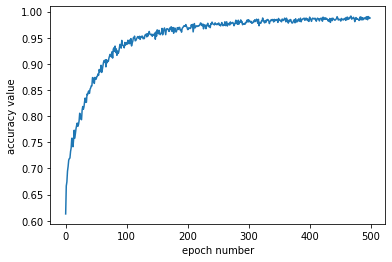

In [ ]:
plt.plot(range(500),history_121.history['accuracy'])
plt.xlabel("epoch number")
plt.ylabel("accuracy value")
plt.show()

74850304/74836368 [==============================] - 1s 0us/step
Epoch 1/500
27/27 - 101s - loss: 0.8893 - accuracy: 0.6170 - val_loss: 0.5743 - val_accuracy: 0.7031 - 101s/epoch - 4s/step
Epoch 2/500
27/27 - 6s - loss: 0.6908 - accuracy: 0.6637 - val_loss: 0.5449 - val_accuracy: 0.7152 - 6s/epoch - 222ms/step
Epoch 3/500
27/27 - 6s - loss: 0.6232 - accuracy: 0.6992 - val_loss: 0.5234 - val_accuracy: 0.7152 - 6s/epoch - 220ms/step
Epoch 4/500
27/27 - 6s - loss: 0.5898 - accuracy: 0.7163 - val_loss: 0.4717 - val_accuracy: 0.7773 - 6s/epoch - 217ms/step
Epoch 5/500
27/27 - 6s - loss: 0.5766 - accuracy: 0.7098 - val_loss: 0.4497 - val_accuracy: 0.7770 - 6s/epoch - 218ms/step
Epoch 6/500
27/27 - 6s - loss: 0.5446 - accuracy: 0.7294 - val_loss: 0.4410 - val_accuracy: 0.8083 - 6s/epoch - 218ms/step
Epoch 7/500
27/27 - 6s - loss: 0.5425 - accuracy: 0.7317 - val_loss: 0.4279 - val_accuracy: 0.8139 - 6s/epoch - 217ms/step
Epoch 8/500
27/27 - 6s - loss: 0.5145 - accuracy: 0.7457 - val_loss: 0.41

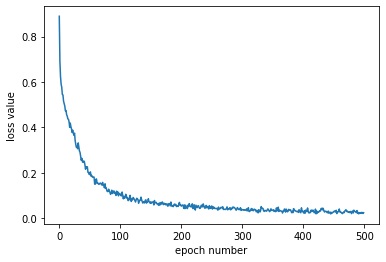

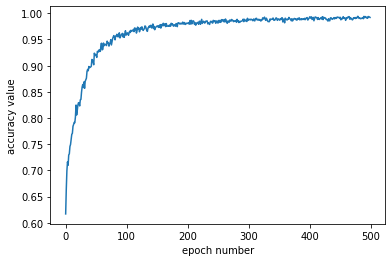

In [ ]:
# same as the DenseNet-121 above but with DenseNet-201

with tpu_strategy.scope():
  model_201 = generate_densenet201()
  model_201.compile(optimizer='Adam',loss='binary_crossentropy',metrics=['accuracy'])
  history_201 = model_201.fit(X_train,y_train,
               steps_per_epoch = X_train.shape[0] //128,
               epochs=500,
               verbose=2,
               callbacks=[], #todo add checkpoints
               validation_data=(X_train, y_train))

In [ ]:
plt.plot(range(500),history_201.history['loss'])
plt.xlabel("epoch number")
plt.ylabel("loss value")
plt.show()
plt.plot(range(500),history_201.history['accuracy'])
plt.xlabel("epoch number")
plt.ylabel("accuracy value")
plt.show()

In [ ]:
with tpu_strategy.scope():
  results = model_201.predict(X_test)
  matrix = [[0,0],[0,0]]
  y_res_flat = [y[0] for y in y_test]
  for real, pred in zip(y_res_flat, results):
    #print(int(pred + 0.5))
    matrix[real][int(pred+0.5)] += 1
  print(matrix)

1
0
0
1
0
1
0
1
0
1
0
0
1
0
0
1
0
0
0
0
0
0
1
0
1
0
0
0
1
0
1
1
1
0
0
1
1
1
0
1
1
0
0
1
0
1
0
1
0
0
0
0
0
0
0
0
0
1
1
0
1
1
0
0
0
0
0
0
0
1
0
1
0
1
0
1
1
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
1
0
0
1
0
1
0
1
0
0
0
0
1
0
0
1
0
0
0
0
0
0
1
0
0
1
0
0
0
0
1
1
1
0
0
0
1
1
0
0
0
1
0
0
1
0
0
1
1
0
1
0
1
0
0
0
0
1
1
0
0
0
0
1
0
0
0
0
1
1
0
1
0
0
1
1
0
0
1
0
1
1
1
1
0
0
0
0
0
0
1
0
1
1
0
0
0
1
0
1
0
1
0
0
1
0
1
0
1
0
0
1
0
0
0
1
1
0
0
0
0
0
1
1
0
0
0
1
1
0
1
1
0
0
0
0
0
0
1
0
0
0
0
1
0
1
1
0
1
0
1
0
1
1
0
1
0
0
0
0
0
0
1
0
0
1
0
1
0
0
0
1
0
1
0
0
0
1
1
1
0
0
1
0
0
0
0
0
1
0
1
0
1
1
0
0
0
0
0
1
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
1
0
1
0
0
1
0
0
0
1
0
0
0
1
1
0
0
1
1
1
1
1
1
1
0
0
0
1
0
1
0
0
0
0
1
1
0
1
0
1
0
0
1
0
0
0
0
1
1
0
0
1
0
0
1
0
0
0
0
0
0
0
1
1
1
0
0
0
1
0
0
0
0
1
1
1
0
1
0
1
0
1
0
0
0
1
0
0
0
1
1
1
1
0
0
0
0
0
0
0
1
0
0
1
1
0
0
1
0
0
0
0
0
1
1
1
0
0
0
0
0
1
1
1
0
0
0
0
0
1
0
1
0
1
0
1
0
0
0
0
1
0
1
1
0
1
0
0
1
1
0
1
0
0
0
0
0
0
1
1
0
1
1
1
1
0
1
1
0
0
1
1
0
0
1
1
0
0
0
1
0
0
